# Evaluation for trained model to decode 32 bits polar code 

In [1]:
import sys, pathlib, pandas as pd

p = pathlib.Path.cwd()
while p != p.parent:
    if (p / "models").exists():
        project_root = p
        break
    p = p.parent

sys.path.insert(0, str(project_root))

In [2]:
import json

In [3]:
import re, matplotlib.pyplot as plt, os

In [4]:
import torch
from dataset import PolarDecDataset 
from models.wrappers.mamba_32bits import MambaPolarDecoder

from torch.utils.data import DataLoader

/home/anjal/Desktop/Code/mamba-seq-pred/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
N = 32

In [9]:
ckpt_path = "../checkpoints/config_7/model_epoch_40.pt" 

In [10]:
ckpt = torch.load(ckpt_path, map_location=device)
ckpt

{'comments': 'Removed the snr as input entirely. (even if used in future, use as snr linear, not in db)',
 'model_config': {'d_model': 32,
  'num_layer_encoder': 1,
  'num_layers_bimamba_block': 8,
  'seq_len': 32,
  'd_state': 16,
  'd_conv': 4,
  'expand': 2},
 'epoch': 41,
 'train_loss': 0.11323442444577814,
 'val_loss': tensor(0.1102, device='cuda:0'),
 'state_dict': OrderedDict([('alpha', tensor(1., device='cuda:0')),
              ('beta', tensor(1., device='cuda:0')),
              ('gamma', tensor(1., device='cuda:0')),
              ('discrete_embedding.weight',
               tensor([[-7.7206e-02,  3.0559e-03,  1.9934e-02,  7.2823e-04, -5.7337e-03,
                         7.4889e-03,  1.3717e-03,  2.7336e-02, -6.1977e-02,  5.3080e-02,
                        -1.6144e-02,  4.8874e-02, -2.0449e-03,  1.8604e-02, -3.6261e-03,
                        -4.1983e-02,  3.0700e-02, -4.5307e-02, -1.5649e-03, -1.1003e-03,
                         5.5514e-02,  7.6736e-02, -5.2748e-02,  9.

In [11]:
model = MambaPolarDecoder(
    d_model=ckpt['model_config']['d_model'],
    num_layer_encoder=ckpt['model_config']['num_layer_encoder'],
    num_layers_bimamba_block=ckpt['model_config']['num_layers_bimamba_block'],
    seq_len=ckpt['model_config']['seq_len'],
    d_state=ckpt['model_config']['d_state'],
    d_conv=ckpt['model_config']['d_conv'],
    expand=ckpt['model_config']['expand']
).to(device)
model

MambaPolarDecoder(
  (discrete_embedding): Embedding(2, 32)
  (linear_embedding1): Linear(in_features=1, out_features=32, bias=True)
  (linear_input_layer): Linear(in_features=64, out_features=32, bias=True)
  (encoder_layers): ModuleList(
    (0): BiMambaEncoder(
      (layers): ModuleList(
        (0-7): 8 x BiMambaBlock(
          (pre_ln_f): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (mamba_f): Mamba(
            (in_proj): Linear(in_features=32, out_features=128, bias=False)
            (conv1d): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(3,), groups=64)
            (act): SiLU()
            (x_proj): Linear(in_features=64, out_features=34, bias=False)
            (dt_proj): Linear(in_features=2, out_features=64, bias=True)
            (out_proj): Linear(in_features=64, out_features=32, bias=False)
          )
          (post_ln_f): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (ffn_f): Sequential(
            (0): Linear(in_feature

### Metrics

In [12]:


# load model
state_dict = ckpt.get("model_state_dict", ckpt.get("state_dict", ckpt))
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [14]:
test_set = PolarDecDataset(snr_db=10, num_samples=32000, fixed_msg_bit_size=32, seq_length=32)
test_dataloader = DataLoader(test_set, batch_size = 32)

In [23]:
channel_tensor, frozen_tensor, snr_tensor, target_tensor= next(iter(test_dataloader))
ip1 = channel_tensor.float().to(device)
ip2 = frozen_tensor.int().to(device)
ip3 = snr_tensor.float().to(device)

#print(ip2[0])

predicted = model(ip1, ip2, ip3) #works

 #loss = calculate_loss_for_reliable_bits_only(ip2, target_tensor.to(device), predicted.to(device), loss_fn) #works


#print(f"Channel Observation Vector: {ip1.shape}\nFrozen Tensor: {ip2.shape}\n")
#print(f"Predicted Channel Input Vector(logits): {predicted.shape}\n\n")

#print(f"Predicted (sigmoid): {torch.sigmoid(predicted)}\n\n")
pred = (torch.sigmoid(predicted) > 0.5).long()[0]

print(f"Actual bits:     {''.join(str(int(i)) for i in target_tensor[0])}\n")
print(f"Predicted bits:  {''.join(map(str, pred.cpu().tolist()))}\n")

#print(f"Loss: {loss}")

Actual bits:     00000011101001101100010110010001

Predicted bits:  11010101011101010100111011011101



In [26]:


def calc_save_ber(model, device , msg_bit_sizes:list, snr_db:list, num_samples=32000, json_file_name=None):
    """
    Calculate BER over a test dataset and saves the detailed data of bit errors for frozen and non frozen bits

    Args:
        test_loader: PyTorch DataLoader providing (channel, frozen, snr, target)
        model: trained model
        device: torch device (cpu or cuda)
    
    Returns:
        float: average BER over the test set
    """

    eval_results = {}

    for each_snr_val in snr_db: 

        print(f"Evaluating for SNR = {each_snr_val}... \n\n")
        ber_list = []
        snr_key = str(each_snr_val) + "_snr"
        eval_results[snr_key] = {}

        for each_msg_bit_size in msg_bit_sizes:

            print(f"Evaluating bit error rates for message bit size {each_msg_bit_size}...\n\n")
        
        
            total_msg_bit_errors = 0
            total_frozen_bit_errors = 0
            total_frozen_bits = 0
            total_msg_bits = num_samples*each_msg_bit_size
           

            test_set = PolarDecDataset(snr_db=each_snr_val, num_samples=num_samples, fixed_msg_bit_size=each_msg_bit_size, seq_length=32)
            test_loader = DataLoader(dataset=test_set, batch_size = 32)

            model.eval()
            with torch.no_grad():
                for i, data in enumerate(test_loader):
                    channel_tensor, frozen_tensor, snr_tensor, target_tensor = data
                    
                    
                    ip1 = channel_tensor.float().to(device)
                    ip2 = frozen_tensor.int().to(device)
                    ip3 = snr_tensor.float().to(device)
                    op = target_tensor.int().to(device)

                #  print(ip3.shape)

                    
                    predicted_vector = model(ip1, ip2, ip3)

                    
                    if predicted_vector.dtype != torch.bool and predicted_vector.dtype != torch.int:
                        predicted_vector = (predicted_vector > 0.5).int()

                    
                    mask_frozen = (ip2 != 0)
                    mask_msg = (ip2 != 1)

                    reliable_target = op[mask_msg]
                    reliable_predicted = predicted_vector[mask_msg]

                    frozen_targets = op[mask_frozen]
                    frozen_predicted = predicted_vector[mask_frozen]

                    
                    msg_bit_errors = (reliable_target != reliable_predicted).sum().item()
                    total_msg_bit_errors += msg_bit_errors
                    
                    frozen_bit_errors = (frozen_targets != frozen_predicted).sum().item()
                    total_frozen_bit_errors += frozen_bit_errors
                    total_frozen_bits += len(frozen_targets)

            
            total_bits = total_msg_bits + total_frozen_bits
            net_error_bits = total_frozen_bit_errors + total_msg_bit_errors

            avg_net_ber = net_error_bits/ total_bits 
            print(f"average_net_bit_error_rate : {avg_net_ber}\n")
            ber_list.append(avg_net_ber)

            avg_msg_bits_ber = total_msg_bit_errors / total_msg_bits
            print(f"average_msg_bit_error_rate : {avg_msg_bits_ber}\n")

            avg_frozen_bits_ber = total_frozen_bit_errors/total_frozen_bits
            print(f"average_frozen_bit_error_rate : {avg_frozen_bits_ber}\n")

          
            
            eval_results[snr_key][each_msg_bit_size] = {
                "average_net_bit_error_rate" : avg_net_ber,
                "average_msg_bit_bit_error_rate": avg_msg_bits_ber,
                "average_frozen_bits_bit_error_rate": avg_frozen_bits_ber,
                "batch_size": test_dataloader.batch_size,
                "num_samples": num_samples,
                "total_bits": total_bits,
                "total_error_bits": net_error_bits,
                "total_msg_bits": total_msg_bits,
                "total_frozen_bits": total_frozen_bits,
              
            }

        

        eval_results[snr_key]['overall_ber'] = sum(ber_list)/len(ber_list)
    
    if json_file_name: 
        with open(f"{json_file_name}.json", "w") as f:
            json.dump(eval_results, f, indent=4)

        print(f"Results saved to {json_file_name}.json file of current directory!")
    

    return eval_results


In [27]:
calc_save_ber(model, device, msg_bit_sizes=[8, 16, 24], snr_db=[4, 6, 8, 10], json_file_name="evaluation_model_config_5")


Evaluating for SNR = 4... 


Evaluating bit error rates for message bit size 8...


average_net_bit_error_rate : 0.057724609375

average_msg_bit_error_rate : 0.2308984375

average_frozen_bit_error_rate : 0.0

Evaluating bit error rates for message bit size 16...


average_net_bit_error_rate : 0.0994873046875

average_msg_bit_error_rate : 0.198974609375

average_frozen_bit_error_rate : 0.0

Evaluating bit error rates for message bit size 24...


average_net_bit_error_rate : 0.19040625

average_msg_bit_error_rate : 0.253875

average_frozen_bit_error_rate : 0.0

Evaluating for SNR = 6... 


Evaluating bit error rates for message bit size 8...


average_net_bit_error_rate : 0.0408515625

average_msg_bit_error_rate : 0.16340625

average_frozen_bit_error_rate : 0.0

Evaluating bit error rates for message bit size 16...


average_net_bit_error_rate : 0.0803701171875

average_msg_bit_error_rate : 0.160740234375

average_frozen_bit_error_rate : 0.0

Evaluating bit error rates for message bit si

{'4_snr': {8: {'average_net_bit_error_rate': 0.057724609375,
   'average_msg_bit_bit_error_rate': 0.2308984375,
   'average_frozen_bits_bit_error_rate': 0.0,
   'batch_size': 32,
   'num_samples': 32000,
   'total_bits': 1024000,
   'total_error_bits': 59110,
   'total_msg_bits': 256000,
   'total_frozen_bits': 768000},
  16: {'average_net_bit_error_rate': 0.0994873046875,
   'average_msg_bit_bit_error_rate': 0.198974609375,
   'average_frozen_bits_bit_error_rate': 0.0,
   'batch_size': 32,
   'num_samples': 32000,
   'total_bits': 1024000,
   'total_error_bits': 101875,
   'total_msg_bits': 512000,
   'total_frozen_bits': 512000},
  24: {'average_net_bit_error_rate': 0.19040625,
   'average_msg_bit_bit_error_rate': 0.253875,
   'average_frozen_bits_bit_error_rate': 0.0,
   'batch_size': 32,
   'num_samples': 32000,
   'total_bits': 1024000,
   'total_error_bits': 194976,
   'total_msg_bits': 768000,
   'total_frozen_bits': 256000},
  'overall_ber': 0.11587272135416667},
 '6_snr': {8: 

## Some plots

### SNR vs BER for different models

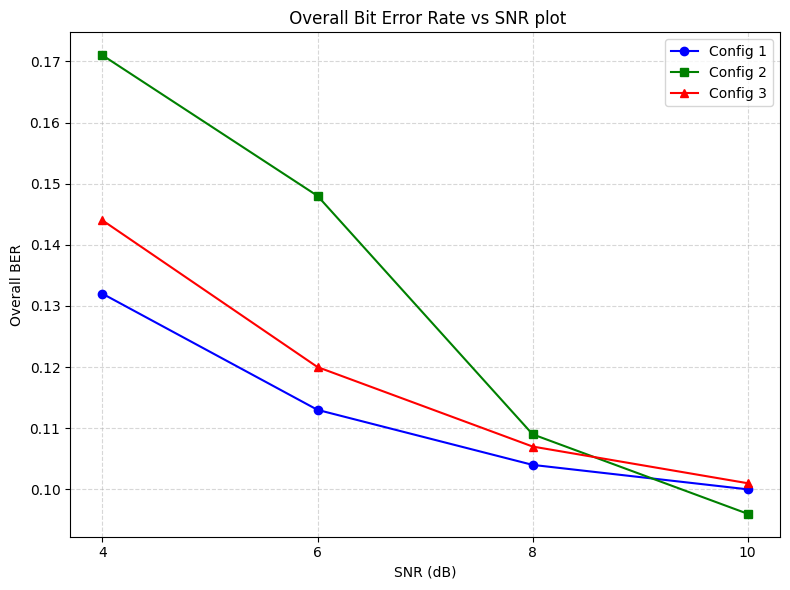

In [108]:


# --- JSON filenames ---
model_files = {
    "Config 1": "evaluation_model_config_3.json",
    "Config 2": "evaluation_model_config_4.json",
    "Config 3": "evaluation_model_config_5.json"
}

# --- Load all eval results ---
eval_results = {}
for model_name, file_name in model_files.items():
    if not os.path.exists(file_name):
        raise FileNotFoundError(f"{file_name} not found in current directory")
    with open(file_name, 'r') as f:
        eval_results[model_name] = json.load(f)

# --- Extract SNRs (assume same SNRs across models) ---
snr_keys = sorted([int(k.split('_')[0]) for k in eval_results["Config 1"].keys()])
snrs = snr_keys  # e.g., [4,6,8,10]

# --- Prepare overall BER for each model ---
ber_values = {}
for model_name, results in eval_results.items():
    ber_values[model_name] = [results[f"{snr}_snr"]["overall_ber"] for snr in snrs]

# --- Plot ---
plt.figure(figsize=(8,6))
colors = ['blue', 'green', 'red']
markers = ['o', 's', '^']

for (model_name, ber), color, marker in zip(ber_values.items(), colors, markers):
    plt.plot(snrs, [round(b, 3) for b in ber], marker=marker, color=color, label=model_name)

plt.xlabel("SNR (dB)")
plt.ylabel("Overall BER")
plt.title(" Overall Bit Error Rate vs SNR plot")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.xticks(snrs)
plt.tight_layout()
plt.show()


### Loss trend for Config 1 (3 actually)

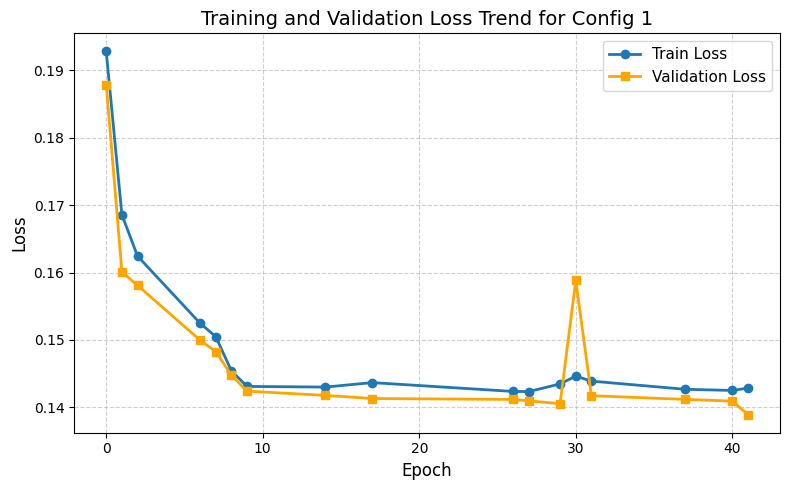

In [116]:
ckpt_dir = pathlib.Path("../checkpoints/config_3")  
pattern = re.compile(r"model_epoch_(\d+)\.pt$")

records = []


for ckpt_file in ckpt_dir.glob("model_epoch_*.pt"):
  
    m = pattern.search(ckpt_file.name)
    if not m:
        continue
    epoch = int(m.group(1))
    ckpt = torch.load(ckpt_file, map_location="cpu")
    train_loss = ckpt.get("train_loss")
   
    valid_loss = ckpt.get("val_loss")
    if train_loss is not None and valid_loss is not None:
        records.append((epoch, train_loss, valid_loss))



records.sort(key=lambda x: x[0])

epochs = [r[0] for r in records]
train_losses = [r[1] for r in records]

valid_losses = [r[2] for r in records]


plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss', linewidth=2)
plt.plot(epochs, valid_losses, marker='s', label='Validation Loss', linewidth=2, color='orange')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss Trend for Config 1", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()



### Msg Bit Size vs Net Bit Error Rate for Config 3

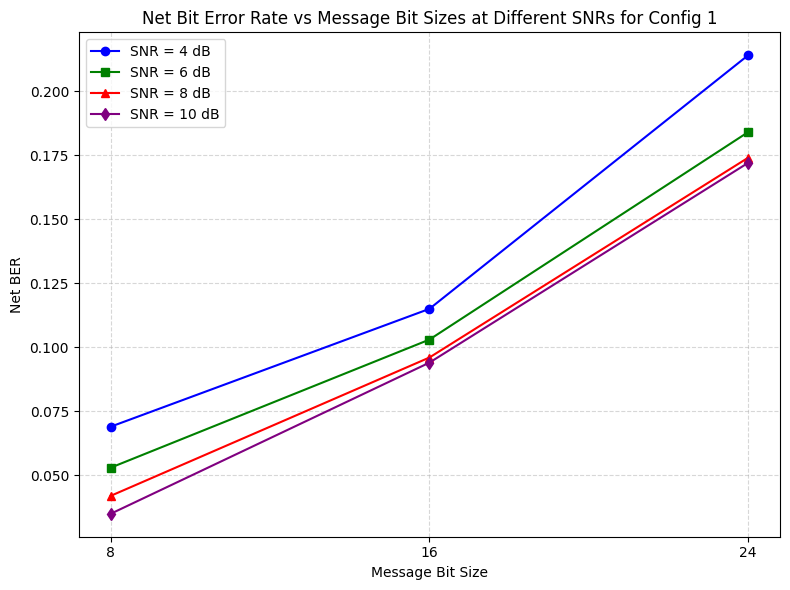

In [119]:



# --- Load JSON for config 3 ---
file_name = "evaluation_model_config_3.json"
if not os.path.exists(file_name):
    raise FileNotFoundError(f"{file_name} not found in current directory")

with open(file_name, 'r') as f:
    eval_data = json.load(f)

# --- Extract SNRs ---
snr_keys = sorted([int(k.split('_')[0]) for k in eval_data.keys() if "_snr" in k])

# --- Extract message bit sizes from one SNR entry (keys are strings) ---
first_snr_key = f"{snr_keys[0]}_snr"
message_bit_sizes = sorted([int(k) for k in eval_data[first_snr_key].keys() if k != "overall_ber"])

# --- Prepare data ---
ber_vs_msg_bits = {}
for snr in snr_keys:
    snr_key = f"{snr}_snr"
    # convert message bit size to string when accessing JSON
    ber_vs_msg_bits[snr] = [eval_data[snr_key][str(mb)]["average_net_bit_error_rate"] for mb in message_bit_sizes]

# --- Plot ---
plt.figure(figsize=(8,6))
markers = ['o','s','^','d','x']  # markers for multiple SNRs
colors = ['blue','green','red','purple','orange']

for idx, snr in enumerate(snr_keys):
    plt.plot(message_bit_sizes, 
             [round(b,3) for b in ber_vs_msg_bits[snr]], 
             marker=markers[idx%len(markers)], 
             color=colors[idx%len(colors)], 
             label=f"SNR = {snr} dB")

plt.xlabel("Message Bit Size")
plt.ylabel("Net BER")
plt.title("Net Bit Error Rate vs Message Bit Sizes at Different SNRs for Config 1")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(message_bit_sizes)
plt.legend()
plt.tight_layout()
plt.show()

